In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

BASE = "/content/drive/MyDrive/airport_lighting_project"
DATA_DIR = os.path.join(BASE, "data")
MODEL_DIR = os.path.join(BASE, "models")

print("Base folder:", BASE)
print("Files in data/:", os.listdir(DATA_DIR))
print("Files in models/:", os.listdir(MODEL_DIR))

!pip install -q numpy pandas matplotlib joblib


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base folder: /content/drive/MyDrive/airport_lighting_project
Files in data/: ['data_meta.json', 'data_preopt.csv', 'data_postopt_rule.csv']
Files in models/: ['rf_pre.pkl', 'rf_post.pkl']


P1 — Load datasets & sanity checks

In [ ]:
import pandas as pd
import numpy as np
import os

BASE = "/content/drive/MyDrive/airport_lighting_project"
pre_path  = os.path.join(BASE, "data", "data_preopt.csv")
post_path = os.path.join(BASE, "data", "data_postopt_rule.csv")

pre  = pd.read_csv(pre_path)
post = pd.read_csv(post_path)

print("Pre shape :", pre.shape)
print("Post shape:", post.shape)
print("\nPre columns :", pre.columns.tolist())
print("Post columns:", post.columns.tolist())

# Ensure timestamps are datetime
for df in [pre, post]:
    if df["timestamp"].dtype == object:
        df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time (optional but clean)
pre  = pre.sort_values("timestamp")
post = post.sort_values("timestamp")

print("Time range PRE :", pre["timestamp"].min(), "→", pre["timestamp"].max())
print("Time range POST:", post["timestamp"].min(), "→", post["timestamp"].max())

# Total energy (kWh)
E_pre  = pre["energy_kWh"].sum()
E_post = post["energy_kWh"].sum()
savings_pct = (E_pre - E_post) / E_pre * 100

print("\n===== TOTAL ENERGY (SIMULATOR) =====")
print(f"Pre-opt  : {E_pre:.3f} kWh")
print(f"Post-opt : {E_post:.3f} kWh")
print(f"Saved    : {savings_pct:.2f}%")

# Per-zone totals
zone_pre  = pre.groupby("zone")["energy_kWh"].sum().sort_index()
zone_post = post.groupby("zone")["energy_kWh"].sum().sort_index()

print("\n===== PER-ZONE ENERGY (kWh) =====")
zone_df = pd.DataFrame({
    "pre_kWh" : zone_pre,
    "post_kWh": zone_post,
    "saved_%": (zone_pre - zone_post) / zone_pre * 100
})
print(zone_df)


Pre shape : (17280, 17)
Post shape: (17280, 10)

Pre columns : ['zone', 'timestamp', 'time_min', 'area_m2', 'daylight_lux', 'occupancy', 'glare', 'temp_C', 'current_dim', 'dim_source', 'max_artificial_lux', 'lamp_power_W', 'num_lamps', 'total_power_W', 'sensor_lux', 'energy_kWh', 'target_lux']
Post columns: ['zone', 'timestamp', 'daylight_lux', 'occupancy', 'glare', 'temp_C', 'dim_used', 'sensor_lux', 'energy_kWh', 'target_lux']
Time range PRE : 2025-01-01 00:00:00 → 2025-01-30 23:50:00
Time range POST: 2025-01-01 00:00:00 → 2025-01-30 23:50:00

===== TOTAL ENERGY (SIMULATOR) =====
Pre-opt  : 14089.890 kWh
Post-opt : 11407.272 kWh
Saved    : 19.04%

===== PER-ZONE ENERGY (kWh) =====
                     pre_kWh     post_kWh    saved_%
zone                                                
checkin+arrival  8194.367235  6587.537357  19.608956
gate               32.395442    21.299167  34.252582
lounge            419.882020   276.791667  34.078705
security         5443.245698  4521.644098  

Plot 1 — Total pre vs post (single bar chart)

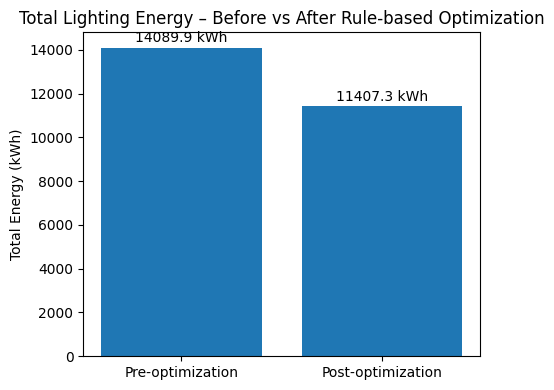

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
labels = ["Pre-optimization", "Post-optimization"]
vals   = [E_pre, E_post]

plt.bar(labels, vals)
plt.ylabel("Total Energy (kWh)")
plt.title("Total Lighting Energy – Before vs After Rule-based Optimization")

for i, v in enumerate(vals):
    plt.text(i, v*1.01, f"{v:.1f} kWh", ha="center", va="bottom")

plt.tight_layout()
plt.show()


Plot 2 — Per-zone pre vs post + savings

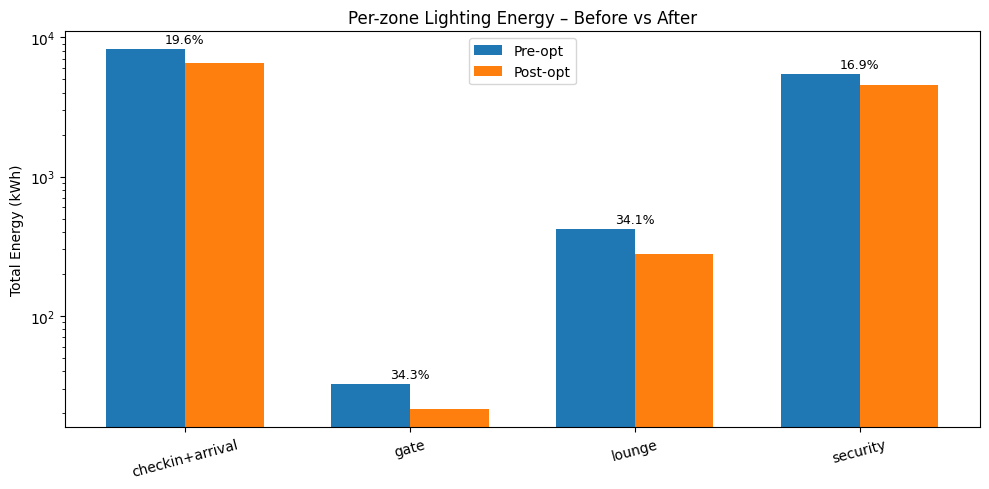

In [7]:
import numpy as np
import matplotlib.pyplot as plt

zones = zone_pre.index.tolist()
x = np.arange(len(zones))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, zone_pre.values,  width, label="Pre-opt")
plt.bar(x + width/2, zone_post.values, width, label="Post-opt")

plt.xticks(x, zones, rotation=15)
plt.ylabel("Total Energy (kWh)")
plt.title("Per-zone Lighting Energy – Before vs After")
plt.legend()

# 🔥 MAKE SMALL ZONES VISIBLE
plt.yscale("log")   # <--- THIS FIX

# annotate savings %
for i, z in enumerate(zones):
    s = (zone_pre[z] - zone_post[z]) / zone_pre[z] * 100
    plt.text(
        x[i],
        max(zone_pre[z], zone_post[z]) * 1.05,
        f"{s:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


Plot 3 — Time-series energy profile (one zone or all zones)

/tmp/ipython-input-3365488610.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pre_hourly  = pre_ts["energy_kWh"].resample("1H").sum()
/tmp/ipython-input-3365488610.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  post_hourly = post_ts["energy_kWh"].resample("1H").sum()


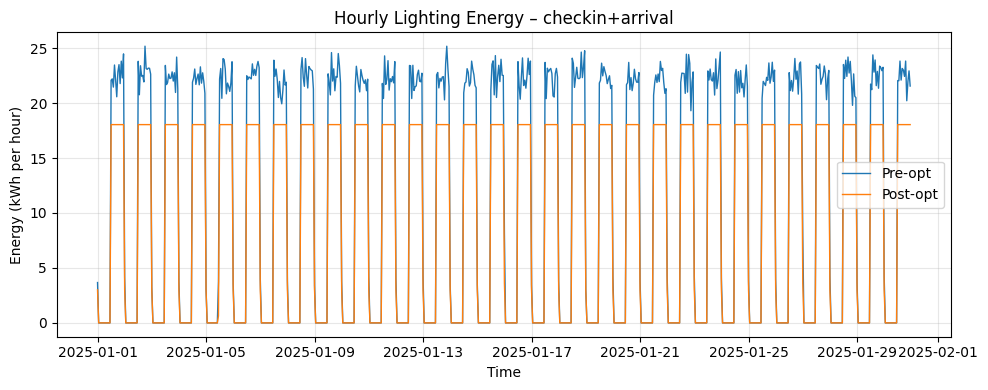

In [8]:
import matplotlib.pyplot as plt

# choose one zone; your updated zone is "checkin+arrival"
zone_to_plot = "checkin+arrival"   # or "security", "lounge", "gate" or None for all zones

pre_ts  = pre.copy()
post_ts = post.copy()

if zone_to_plot is not None:
    pre_ts  = pre_ts[pre_ts["zone"] == zone_to_plot]
    post_ts = post_ts[post_ts["zone"] == zone_to_plot]

pre_ts  = pre_ts.set_index("timestamp")
post_ts = post_ts.set_index("timestamp")

# hourly sums
pre_hourly  = pre_ts["energy_kWh"].resample("1H").sum()
post_hourly = post_ts["energy_kWh"].resample("1H").sum()

plt.figure(figsize=(10,4))
plt.plot(pre_hourly.index,  pre_hourly.values,  label="Pre-opt",  linewidth=1)
plt.plot(post_hourly.index, post_hourly.values, label="Post-opt", linewidth=1)

title_zone = f" – {zone_to_plot}" if zone_to_plot is not None else ""
plt.title(f"Hourly Lighting Energy{title_zone}")
plt.ylabel("Energy (kWh per hour)")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Plot 4 — Histogram of per-timestep energy (distribution change)

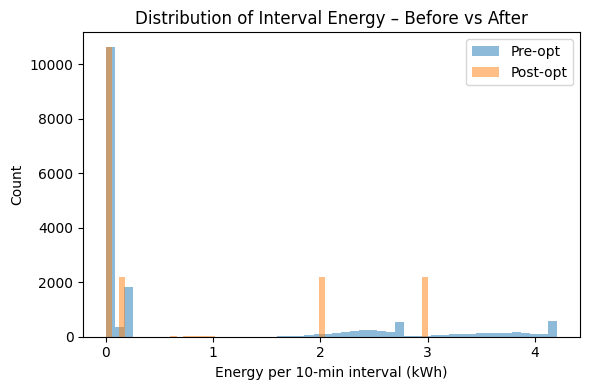

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(pre["energy_kWh"],  bins=50, alpha=0.5, label="Pre-opt")
plt.hist(post["energy_kWh"], bins=50, alpha=0.5, label="Post-opt")

plt.xlabel("Energy per 10-min interval (kWh)")
plt.ylabel("Count")
plt.title("Distribution of Interval Energy – Before vs After")
plt.legend()
plt.tight_layout()
plt.show()


Plot 5 — RF scatter for PRE model

RF_pre — R²: 1.0000, RMSE: 0.000468 kWh


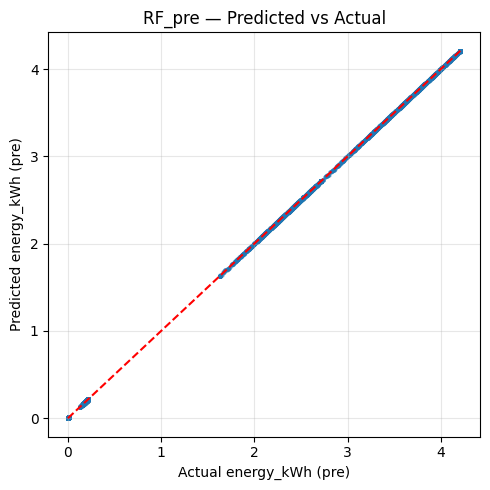

In [10]:
import joblib
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

rf_pre = joblib.load(os.path.join(MODEL_DIR, "rf_pre.pkl"))

# IMPORTANT: match the NEW training features
feat_pre = [
    "area_m2","time_min","daylight_lux","occupancy","glare",
    "temp_C","current_dim","max_artificial_lux",
    "lamp_power_W","num_lamps","total_power_W","target_lux"
]

X_pre  = pre[feat_pre]
y_true_pre = pre["energy_kWh"]
y_pred_pre = rf_pre.predict(X_pre)

r2_p  = r2_score(y_true_pre, y_pred_pre)
rmse_p = np.sqrt(mean_squared_error(y_true_pre, y_pred_pre))

print(f"RF_pre — R²: {r2_p:.4f}, RMSE: {rmse_p:.6f} kWh")

plt.figure(figsize=(5,5))
plt.scatter(y_true_pre, y_pred_pre, s=5, alpha=0.4)
mx = max(y_true_pre.max(), y_pred_pre.max())
plt.plot([0, mx], [0, mx], 'r--')
plt.xlabel("Actual energy_kWh (pre)")
plt.ylabel("Predicted energy_kWh (pre)")
plt.title("RF_pre — Predicted vs Actual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Plot 6 - RF scatter for POST model (with fixed merge)

Missing features for post RF: []
RF_post — R²: 1.0000, RMSE: 0.003233 kWh


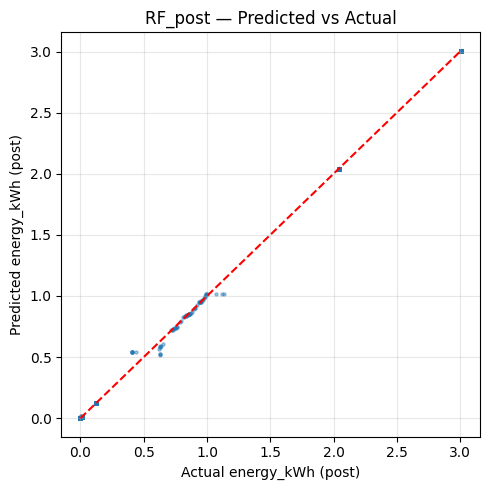

In [11]:
import joblib
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

rf_post = joblib.load(os.path.join(MODEL_DIR, "rf_post.pkl"))

# Merge post with pre metadata (including new power fields)
merged_post = post.merge(
    pre[[
        "zone","timestamp",
        "area_m2","time_min",
        "max_artificial_lux","lamp_power_W",
        "num_lamps","total_power_W",
        "target_lux"
    ]],
    on=["zone","timestamp"],
    how="left",
    suffixes=("","_pre")
)

# Fix target_lux columns if duplicated
if "target_lux_x" in merged_post.columns and "target_lux" not in merged_post.columns:
    merged_post = merged_post.rename(columns={"target_lux_x": "target_lux"})
if "target_lux_y" in merged_post.columns:
    merged_post = merged_post.drop(columns=["target_lux_y"])

feat_post = [
    "area_m2","time_min","daylight_lux","occupancy","glare",
    "temp_C","dim_used","max_artificial_lux",
    "lamp_power_W","num_lamps","total_power_W","target_lux"
]

missing = [c for c in feat_post if c not in merged_post.columns]
print("Missing features for post RF:", missing)
if missing:
    raise ValueError("Some required features for RF_post are missing. See list above.")

X_post  = merged_post[feat_post]
y_true_post = merged_post["energy_kWh"]
y_pred_post = rf_post.predict(X_post)

r2_po  = r2_score(y_true_post, y_pred_post)
rmse_po = np.sqrt(mean_squared_error(y_true_post, y_pred_post))

print(f"RF_post — R²: {r2_po:.4f}, RMSE: {rmse_po:.6f} kWh")

plt.figure(figsize=(5,5))
plt.scatter(y_true_post, y_pred_post, s=5, alpha=0.4)
mx = max(y_true_post.max(), y_pred_post.max())
plt.plot([0, mx], [0, mx], 'r--')
plt.xlabel("Actual energy_kWh (post)")
plt.ylabel("Predicted energy_kWh (post)")
plt.title("RF_post — Predicted vs Actual")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Plot 7: Savings pie chart

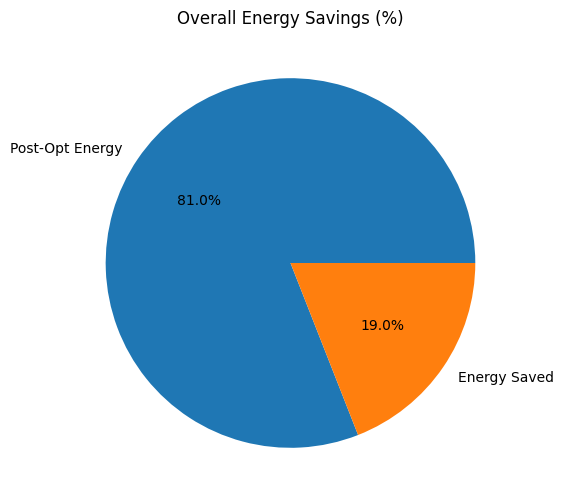

In [12]:
import matplotlib.pyplot as plt

savings_abs = E_pre - E_post

plt.figure(figsize=(6,6))
plt.pie(
    [E_post, savings_abs],
    labels=["Post-Opt Energy", "Energy Saved"],
    autopct="%1.1f%%"
)
plt.title("Overall Energy Savings (%)")
plt.show()


Plot 8: Daily total energy consumption (pre vs post)

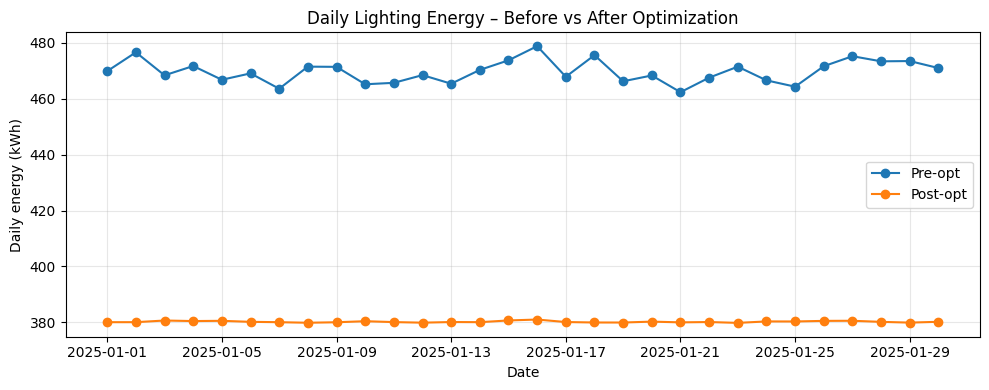

In [14]:
import matplotlib.pyplot as plt

pre_daily  = pre.set_index("timestamp")["energy_kWh"].resample("1D").sum()
post_daily = post.set_index("timestamp")["energy_kWh"].resample("1D").sum()

plt.figure(figsize=(10,4))
plt.plot(pre_daily.index,  pre_daily.values,  label="Pre-opt",  marker="o")
plt.plot(post_daily.index, post_daily.values, label="Post-opt", marker="o")

plt.xlabel("Date")
plt.ylabel("Daily energy (kWh)")
plt.title("Daily Lighting Energy – Before vs After Optimization")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Per-zone hourly profile comparison

/tmp/ipython-input-1087993453.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h_pre  = pre[pre["zone"]==z].set_index("timestamp")["energy_kWh"].resample("1H").sum()
/tmp/ipython-input-1087993453.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h_post = post[post["zone"]==z].set_index("timestamp")["energy_kWh"].resample("1H").sum()


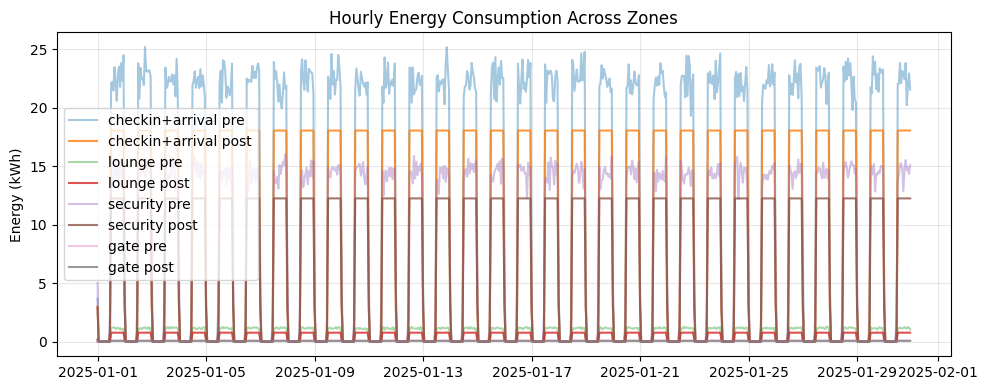

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

for z in pre["zone"].unique():
    h_pre  = pre[pre["zone"]==z].set_index("timestamp")["energy_kWh"].resample("1H").sum()
    h_post = post[post["zone"]==z].set_index("timestamp")["energy_kWh"].resample("1H").sum()
    plt.plot(h_pre.index,  h_pre.values,  label=f"{z} pre",  alpha=0.4)
    plt.plot(h_post.index, h_post.values, label=f"{z} post", alpha=0.8)

plt.title("Hourly Energy Consumption Across Zones")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Plot 10: Daylight vs dimming (post)

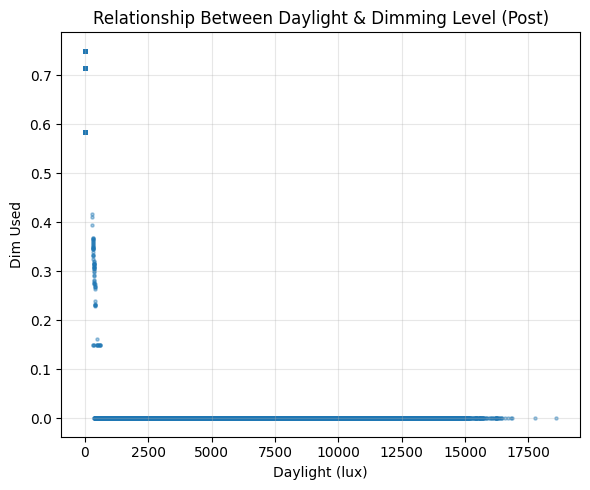

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(post["daylight_lux"], post["dim_used"], s=5, alpha=0.4)
plt.title("Relationship Between Daylight & Dimming Level (Post)")
plt.xlabel("Daylight (lux)")
plt.ylabel("Dim Used")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Energy Savings Over Time (Daily Savings Trend)

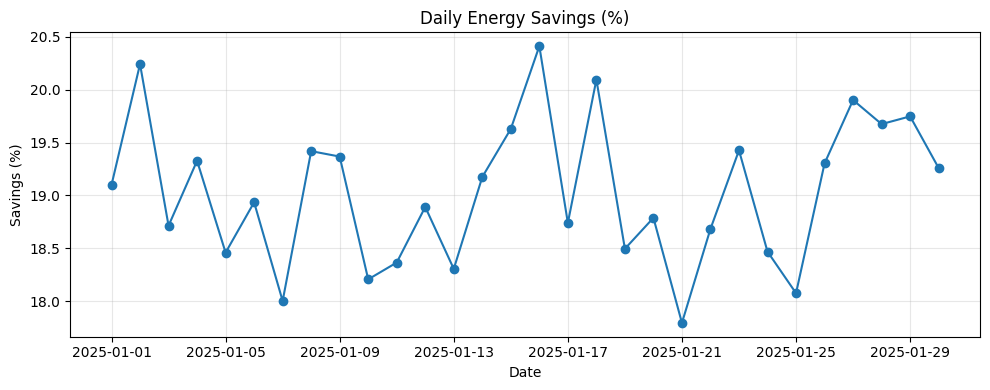

In [17]:
import matplotlib.pyplot as plt

pre_daily  = pre.set_index("timestamp")["energy_kWh"].resample("1D").sum()
post_daily = post.set_index("timestamp")["energy_kWh"].resample("1D").sum()

daily_savings = (pre_daily - post_daily) / pre_daily * 100

plt.figure(figsize=(10,4))
plt.plot(daily_savings.index, daily_savings.values, marker="o")
plt.title("Daily Energy Savings (%)")
plt.ylabel("Savings (%)")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Dimming Response Curve — Baseline (pre) vs Rule-based (post)    
*(curve showing how dimming changes with daylight before and after optimization.)*